In [1]:
## This version excludes CONTINUOUS Variables and the RFD variables AND _wHICH VARIABLES 3/27/2024 and con_max_consultorder_time/day and drg name
## 4/4/2024 Added QUINTILE variables
## 4/8/2024 Added QUINTILE varables by service
## 4/9/2024 Added more consult and imaging variables (e.g. ad,it order to consult order, admit order to imaging read)
## 4/11/2024 Added QUINTILE variables by service for the additional variables
## 4/13/2024 Added con_unique_services_which and con_unique_services_which2 variables
## 4/16/2024 Updated criteria for heart failure and GI

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.encoding import OneHotEncoder
from feature_engine.selection import DropFeatures, DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.imputation import AddMissingIndicator
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from feature_engine.discretisation import DecisionTreeDiscretiser
from sklearn.model_selection import GroupShuffleSplit

from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import RareLabelEncoder
from sklearn.impute import SimpleImputer

#pip install xgboost==0.90
import xgboost as xgb
import plotly.express as px
import shap

#https://github.com/liannewriting/YouTube-videos-public/blob/main/xgboost-python-tutorial-example/xgboost_python.ipynb
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
#hyperparameter values
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, classification_report, precision_recall_curve
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_all = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/clean/master_los.csv', index_col=[0])

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df_all["viz_service_collapsed"].value_counts()

viz_service_collapsed
Medicine             10192
Cardiology            1694
Neurology              889
Surgical Services      430
Name: count, dtype: int64

In [6]:
df_all["viz_disp_collapsed"].value_counts()

viz_disp_collapsed
Other    8346
Home     4859
Name: count, dtype: int64

In [7]:
df_all["thro_boarding_yn"].value_counts()

thro_boarding_yn
1.0    6895
0.0    5585
Name: count, dtype: int64

In [8]:
df_all["viz_drg"].value_counts()

viz_drg
Septicemia or severe sepsis w/o mv >96 hours w mcc                                           2080
heart failure & shock w mcc                                                                  1390
Respiratory infections & inflammations w mcc                                                 1066
Esophagitis, gastroent & misc digest disorders w/o mcc                                        682
Simple pneumonia & pleurisy w mcc                                                             640
Cellulitis w/o mcc                                                                            456
Renal failure w mcc                                                                           438
Septicemia or severe sepsis w/o mv >96 hours w/o mcc                                          437
Pulmonary edema & respiratory failure                                                         430
Infectious & parasitic diseases w o.r. procedure w mcc                                        353
Intracranial

In [9]:
#Filter for home patients
#df_filt = df_all.copy()
df_filt = df_all[(df_all["viz_service_collapsed"]=="Neurology") & (df_all["viz_disp_collapsed"] == "Home")]
#df_filt = df_all[df_all["viz_drg"]=="heart failure & shock w mcc"].copy()
#df_filt = df_all[df_all["viz_disp_collapsed"] == "Home"].copy()
#df_filt = df_all[df_all["thro_boarding_yn"] == 1].copy()

In [10]:
df_filt.shape

(295, 922)

In [11]:
# aitc_features.xlsx includes all the feature names and corresponding types
features_los = pd.read_excel('/gpfs/milgram/project/rtaylor/imc33/data/clean/features_los.xlsx')

# Features that are divided into 5 types to conduct data preprocessing
# 1. drop: features that need to be dropped
drop_list = features_los[features_los['type'] == 'drop']['col_name'].tolist()

# 2. category: features that are already categorical and need to be OneHotEncoding (add missing value indicator, impute missing by adding 'missing' category)
category_list = features_los[features_los['type'] == 'category']['col_name'].tolist()

# 3. binary: features that are binary and need to be converted to categorical (add missing value indicator / prefer: fill missing with 0)
binary_list = features_los[features_los['type'] == 'binary']['col_name'].tolist()

# 4. continuous: features that are continous/numerical variables, need outlier handling and normalization (add missing value indicator, fill missing with median)
continuous_list = features_los[features_los['type'] == 'continuous']['col_name'].tolist()

# 5. discrete: features that are discrete/numerical variables, need to be discretized (fill missing with 0)
discrete_list = features_los[features_los['type'] == 'discrete']['col_name'].tolist()

In [12]:
# Identify variables with infinite values
#variables_with_inf = df_filt.columns[df_filt.isin([np.inf, -np.inf]).any()]

# Handle infinite values (e.g., replace with NaN)
#df_filt[variables_with_inf] = df_filt[variables_with_inf].replace([np.inf, -np.inf], np.nan)

In [13]:
# Split into X, y
X = df_filt.drop(['viz_outcome_prolonged_los_yn'], axis=1)
y = df_filt['viz_outcome_prolonged_los_yn']

In [14]:
# Convert variables to categorical
X[binary_list] = X[binary_list].astype('category')
X[category_list] = X[category_list].astype('category')

In [15]:
# Drop features that have >= 99% missing values And features in drop list
missing_pct = X.isnull().mean() * 100
cols_to_drop = missing_pct[missing_pct >= 99].index.tolist()
#final_drop_list = list(set(drop_list + cols_to_drop))
#X_1b = X_1b.drop(columns=final_drop_list)
#X_1b = X_1b.reset_index(drop=True)
#y_1b = y_1b.reset_index(drop=True)

In [16]:
pd.set_option('display.max_rows', 400)

In [17]:
missing_pct.reset_index().sort_values(0, ascending=False).head()

,index,0
810,img_max_order_to_completion_echo_hrs,100.0
873,img_max_admit_order_to_imaging_order_us_quinti...,100.0
723,con_avg_admit_order_to_consult_completion_picc...,100.0
709,con_avg_admit_order_to_consult_order_addiction...,100.0
726,con_avg_admit_order_to_consult_completion_radi...,100.0


In [18]:
continuous_list.remove("viz_age")

In [19]:
# We do NOT want to drop these
#cols_to_drop
#only these
drop_list

['rfd_first_nmr_start_day',
 'rfd_first_nmr_start_time',
 'rfd_first_mrnb_start_day',
 'rfd_first_mrnb_start_time',
 'rfd_first_mrwb_start_day',
 'rfd_first_mrwb_start_time',
 'rfd_last_nmr_effective_end_day',
 'rfd_last_nmr_effective_end_time',
 'rfd_last_mrnb_effective_end_day',
 'rfd_last_mrnb_effective_end_time',
 'rfd_last_mrwb_effective_end_day',
 'rfd_last_mrwb_effective_end_time',
 'con_max_consult_order_to_sign_which',
 'con_max_consult_order_time',
 'con_max_consult_order_day',
 'con_max_date_note_signed_time1',
 'con_max_date_note_signed_day1',
 'con_max_consult_note_to_sign_which',
 'admissiondate',
 'ed_arrival_time',
 'ed_arrival_hour',
 'ed_arrival_date',
 'dischargedate',
 'con_max_consult_order_to_sign_colon_and_rectal_hrs',
 'con_max_consult_order_to_sign_picc_hrs',
 'con_max_consult_order_to_sign_pharmacy_hrs',
 'con_max_consult_order_to_sign_sw_hrs',
 'con_max_admit_order_to_consult_order_any_hrs',
 'con_avg_admit_order_to_consult_order_any_hrs',
 'img_max_admit_ord

In [21]:
X = X.drop(columns=drop_list+continuous_list)
X = X.reset_index()
y = y.reset_index()

In [22]:
# Split the data by group shuffle split on 'PAT_MRN_ID' into train set and validation set
gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)

train_ix, val_ix = next(gss.split(X, y, groups=X['pat_mrn_id']))

X_train = X.loc[train_ix]
y_train = y.loc[train_ix]

X_val = X.loc[val_ix]
y_val = y.loc[val_ix]

# Drop 'PAT_MRN_ID' and set 'PAT_ENC_CSN_ID' as index
X_train = X_train.drop(['pat_mrn_id'], axis=1).set_index('pat_enc_csn_id')
X_val = X_val.drop(['pat_mrn_id'], axis=1).set_index('pat_enc_csn_id')

### Feature Processing

In [23]:

# Update feature preprocessing pipeline
feature_preprocess_pipeline = Pipeline(steps=[

    # Missing value indicator for categoricals and continuous variables
    #('missing_indicator', AddMissingIndicator(variables=category_list + continuous_list)),

    # Missing value imputation
    # Impute missing values with 0 for discrete variables
    ('arbitrary_number_imputer', ArbitraryNumberImputer(arbitrary_number=0, variables=discrete_list)),

  
    # Impute missing values with adding 'missing' category for categorical variables 
   ('categorical_imputer', CategoricalImputer(variables=category_list)),

    # Impute missing values with 0 for binary variables 
    ('binary_imputer', CategoricalImputer(fill_value='0', variables=binary_list)),

    
    # Rare encoding for categorical variables
    ('rare_label_encoder', RareLabelEncoder(tol=0.01, n_categories=5, max_n_categories=10, variables=category_list)),

    # OneHotEncoding for categoricals
    ('one_hot_category', OneHotEncoder(variables=category_list)),

    # Outlier handling & normalization for continous variables
   #('outlier_handling', Winsorizer(capping_method='gaussian', tail='right', fold=3, variables=continuous_list)),
    #todo: 

  # ('normalize', SklearnTransformerWrapper(MinMaxScaler(feature_range=(0, 1)), variables=continuous_list)),

    # discretize for discrete variables
   #('discretize', DecisionTreeDiscretiser(cv=3, scoring='roc_auc', regression=False, random_state=42, variables=discrete_list))
    #todo:
    
])  # Apply the pipeline

In [24]:
# Apply the pipeline
X_train_preprocessed = feature_preprocess_pipeline.fit_transform(X_train, y_train)
X_val_preprocessed = feature_preprocess_pipeline.transform(X_val)

In [25]:
X_train_preprocessed.shape

(235, 1453)

In [26]:
X_train_preprocessed.to_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_train_preprocessed_byservice_patients_cat_only.csv')
X_val_preprocessed.to_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_val_preprocessed_byservice_patients_cat_only.csv')

### Feature Selection

In [27]:
# 1st Feature Selection pipeline
feature_selection_pipeline = Pipeline(steps=[

        ('drop_constant', DropConstantFeatures(tol=0.99)),

        ('drop_duplicates', DropDuplicateFeatures()),

        ('correlated_features', SmartCorrelatedSelection(
        method='pearson',
        threshold=0.9,
        selection_method='model_performance',
        estimator=xgb.XGBClassifier(random_state=0)
        ))
])

In [28]:
miss_df = X_train_preprocessed.isna().sum().reset_index()
miss_df[miss_df[0]>0]
miss_df[miss_df[0]>0].to_csv("miss_df.csv", index=False)

In [29]:
# Apply the pipeline
X_train_selected = feature_selection_pipeline.fit_transform(X_train_preprocessed, y_train['viz_outcome_prolonged_los_yn'])
X_val_selected = feature_selection_pipeline.transform(X_val_preprocessed)

In [30]:
X_train_selected.to_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_train_initial_selected_byservice_patients_cat_only.csv')
X_val_selected.to_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_val_initial_selected_byservice_patients_cat_only.csv')

In [31]:
X_train_preprocessed.shape

(235, 1453)

In [32]:
X_train_selected.shape

(235, 481)

In [33]:
# Read files
#X_train_selected = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_train_initial_selected_byservice_patients_cat_only.csv')
#X_val_selected = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_val_initial_selected_byservice_patients_cat_only.csv')

In [34]:
#train_selected = X_train_selected.merge(y_train, on='pat_enc_csn_id', how='left')
#val_selected = X_val_selected.merge(y_val, on='pat_enc_csn_id', how='left')

In [35]:
#train_selected = train_selected.set_index('pat_enc_csn_id')
#val_selected = val_selected.set_index('pat_enc_csn_id')

In [36]:
# Top 20 features - training set
#get_best_features(num_feats = 20, df = train_selected, df_name = 'train', target = 'viz_outcome_prolonged_los_yn')

In [37]:
y_train['viz_outcome_prolonged_los_yn'].sum()/y_train.shape[0]

0.3021276595744681

In [38]:
estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8, verbosity=1))
]

tuning_pipeline = Pipeline(steps=estimators)

In [39]:
search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

model_xgb = BayesSearchCV(tuning_pipeline, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=8) 

In [40]:
#y_train = y_train.set_index('pat_enc_csn_id')

In [41]:
y_train = y_train.set_index('pat_enc_csn_id')

In [42]:
#X_train_selected = X_train_selected.set_index('pat_enc_csn_id')

In [43]:
model_xgb.fit(X_train_selected,  y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=N...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [44]:
model_xgb.best_estimator_

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['thro_boarding_yn',
                                     'summary_pt_consult_order_yn',
                                     'con_max_consult_order_to_sign_is_signer_ym_provider_yn',
                                     'con_max_consult_order_to_sign_is_signer_nemg_provider_yn',
                                     'con_max_consult_order_to_sign_is_signer_community_provider_yn',
                                     'icu_any_icu_yn'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, call...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0031574039841631043,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=8, ...))])

In [45]:
model_xgb.best_score_

0.7507783145464305

In [46]:
y_val = y_val.set_index('pat_enc_csn_id')

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Confusion Matrix

-- Of 5831 people who did not have a prolonged LOS, 5831 (86%) were correctly classified.
-- Of 4724 people who did have prolonged LOS, 3918 (83%) were correctly classified

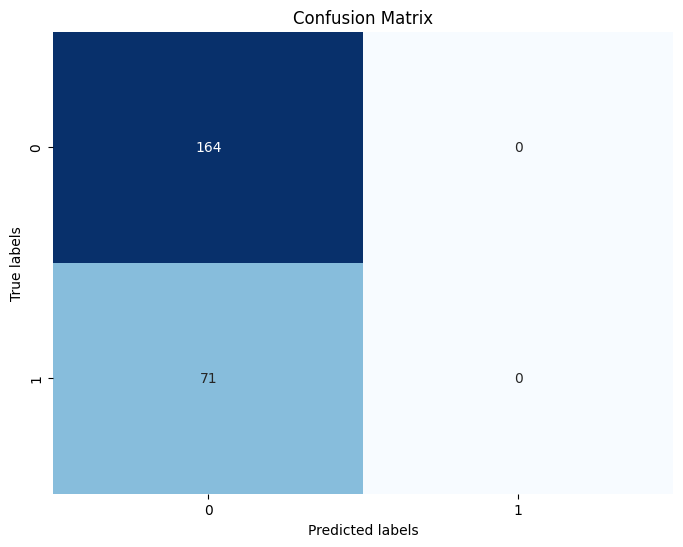

In [48]:
# Generate confusion matrix
cm = confusion_matrix(y_train, model_xgb.predict(X_train_selected))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [49]:
from sklearn import metrics

def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

In [50]:
test_preds = model_xgb.predict(X_val_selected)
target_test = y_val['viz_outcome_prolonged_los_yn']

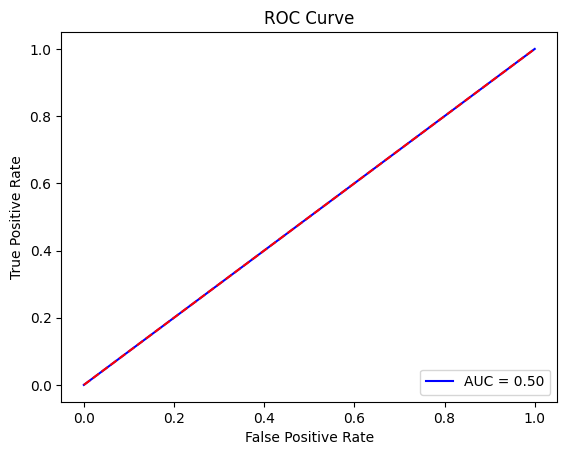

In [51]:
buildROC(target_test, test_preds)

In [52]:
def buildPR(target_test,test_preds):
    precision, recall, _ = metrics.precision_recall_curve(target_test, test_preds)
    pr_auc = metrics.auc(recall, precision)
    plt.title('PR Curve')
    plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f})')
    plt.legend(loc = 'lower right')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

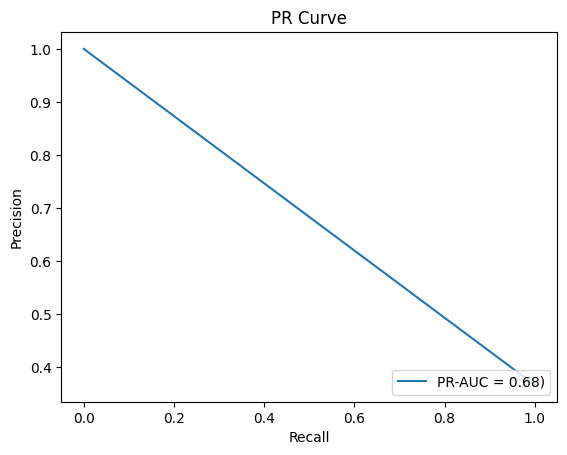

In [53]:
buildPR(target_test, test_preds)

In [54]:
def buildCC(target_test,test_preds):
      prob_true, prob_pred = calibration_curve(target_test, test_preds, n_bins=10)
      plt.plot(prob_pred, prob_true)
      plt.xlabel('Mean Predicted Probability')
      plt.ylabel('Fraction of Positives')

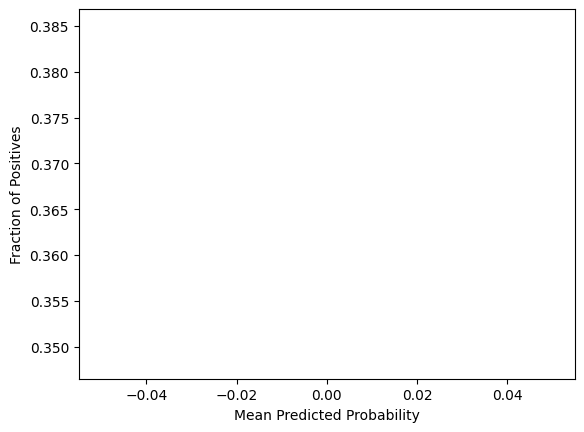

In [55]:
buildCC(target_test, test_preds)

In [56]:
#model_xgb.predict_proba(X_val)

In [57]:
model_xgb.best_estimator_.steps

[('encoder',
  TargetEncoder(cols=['thro_boarding_yn', 'summary_pt_consult_order_yn',
                      'con_max_consult_order_to_sign_is_signer_ym_provider_yn',
                      'con_max_consult_order_to_sign_is_signer_nemg_provider_yn',
                      'con_max_consult_order_to_sign_is_signer_community_provider_yn',
                      'icu_any_icu_yn'])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.6301181140809947,
                colsample_bynode=0.7703817113387359,
                colsample_bytree=0.506103014140404, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=2.079165271399323,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.0031574039841631043,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
            

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

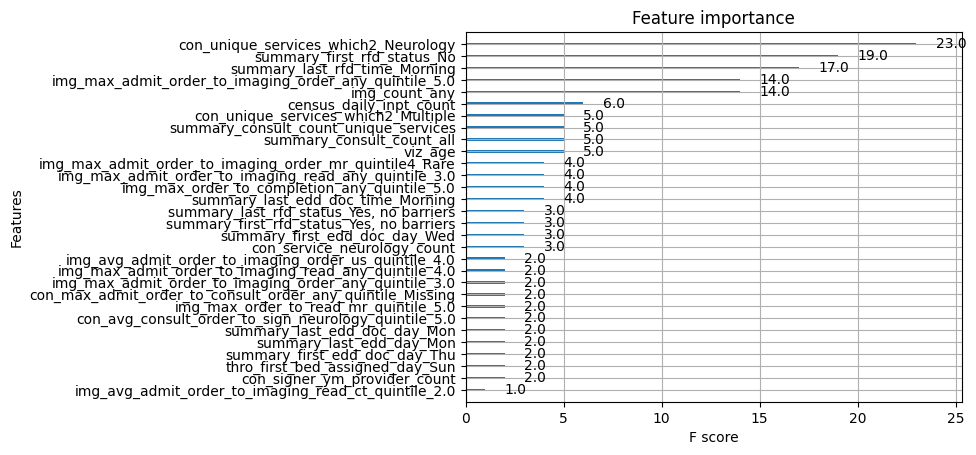

In [58]:
#https://www.youtube.com/watch?v=aLOQD66Sj0g&ab_channel=LianneandJustin
from xgboost import plot_importance

xgboost_step = model_xgb.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model, max_num_features=30)

In [59]:
xgboost_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6301181140809947,
              colsample_bynode=0.7703817113387359,
              colsample_bytree=0.506103014140404, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2.079165271399323,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0031574039841631043,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=8, ...)

In [60]:
X_train_selected = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_train_initial_selected_byservice_patients_cat_only.csv', index_col=[0])

In [61]:
X_val_selected = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/data/pipeline/los_val_initial_selected_byservice_patients_cat_only.csv', index_col=[0])

In [62]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
clf_xgb.fit(X_train_selected, 
            y_train['viz_outcome_prolonged_los_yn'], 
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_val_selected, y_val['viz_outcome_prolonged_los_yn'])])

[0]	validation_0-aucpr:0.65201
[1]	validation_0-aucpr:0.73391
[2]	validation_0-aucpr:0.68706
[3]	validation_0-aucpr:0.66249
[4]	validation_0-aucpr:0.70563
[5]	validation_0-aucpr:0.71691
[6]	validation_0-aucpr:0.68765
[7]	validation_0-aucpr:0.65302
[8]	validation_0-aucpr:0.66067
[9]	validation_0-aucpr:0.66821
[10]	validation_0-aucpr:0.66245


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=None, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [63]:
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_val_selected)

In [64]:
#1 shap value for each feature
np.shape(shap_values.values)

(60, 481)

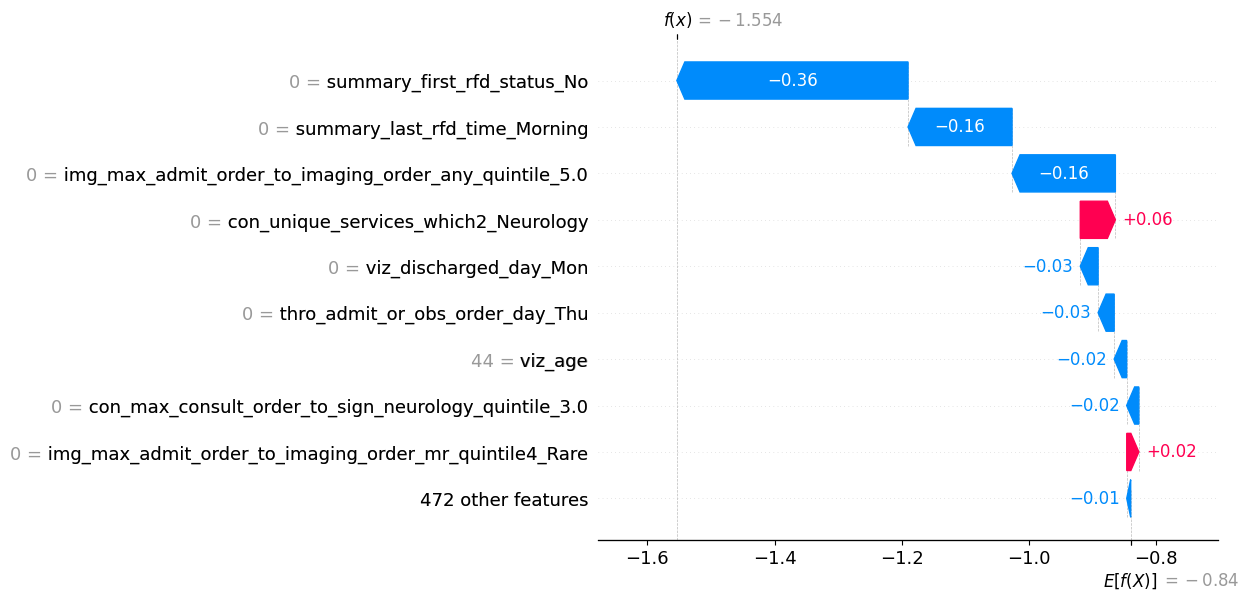

In [65]:
#This is for a single prediction
shap.plots.waterfall(shap_values[0])

In [66]:
shap.initjs(),
shap.plots.force(shap_values[0])

In [67]:
shap.plots.force(shap_values[0:100])

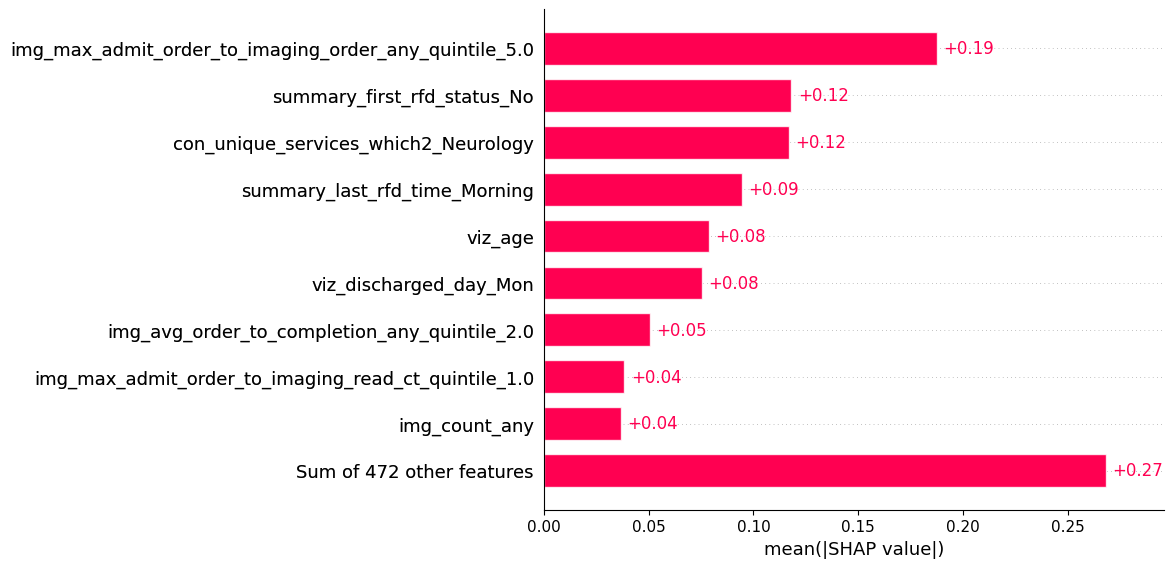

In [68]:
shap.plots.bar(shap_values)

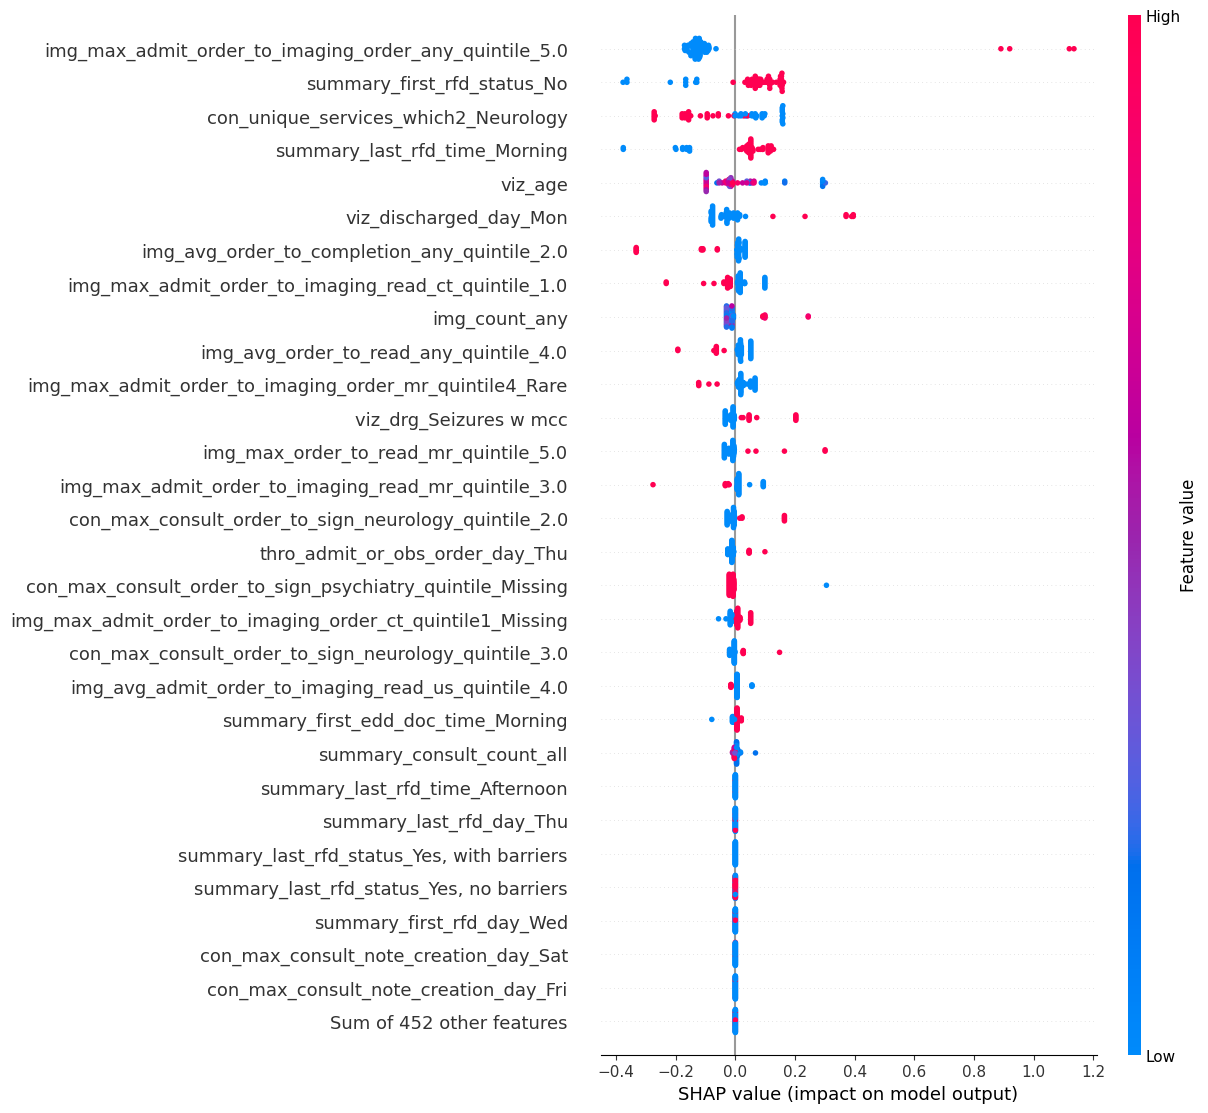

In [69]:
shap.plots.beeswarm(shap_values, max_display=30)